**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [0]:
# # Install the OpenSlide C library and Python bindings
# !apt-get install openslide-tools
# !pip install openslide-python

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
import numpy as np
import tensorflow as tf

In [0]:
img_folder = './img/'
if not os.path.exists(img_folder): 
  os.mkdir(img_folder)

In [0]:
# # Download all images to local folder
# !pip install -U -q PyDrive
# import os
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# file_list = drive.ListFile(
#     {'q': "'1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5' in parents"}).GetList()

# for f in file_list:
#   print('title: %s, id: %s' % (f['title'], f['id']))
#   fname = os.path.join('img',f['title'])
#   print('downloading to {}'.format(fname))
#   f_ = drive.CreateFile({'id': f['id']})
#   f_.GetContentFile(fname)

In [47]:
# Download all images to local folder
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile(
    {'q': "'1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5' in parents"}).GetList()

# for f in file_list:
#   print(f['title'], f['id'])
#   print('title: %s, id: %s' % (f['title'], f['id']))
#   fname = os.path.join(f['title'])
#   print('downloading to {}'.format(fname))
#   f_ = drive.CreateFile({'id': f['id']})
#   f_.GetContentFile(fname)
fname = 'tumor_078.tif'
f_ = drive.CreateFile({'id': '1cAFgPCkGR0zH0gqCDo4yBnstNoZmjp3C'})
f_.GetContentFile(fname)
fname = 'tumor_078_mask.tif'
f_ = drive.CreateFile({'id': '1ZC2urznY3gRebUG3PN2BtYD1ZPZ7GPYq'})
f_.GetContentFile(fname)

KeyboardInterrupt: ignored

In [10]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   142M      0  0:00:03  0:00:03 --:--:--  142M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  48.3M      0 --:--:-- --:--:-- --:--:-- 48.2M


In [11]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

(840, 960, 3)


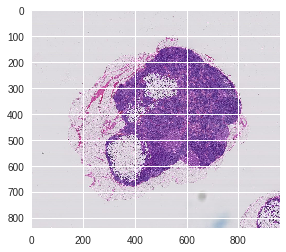

In [13]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

zoom_level = 6

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=zoom_level, 
                         width=slide.level_dimensions[zoom_level][0], 
                         height=slide.level_dimensions[zoom_level][1])

# plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
print(slide_image.shape)

(840, 960)


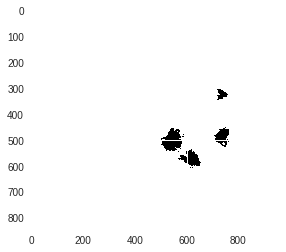

In [14]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=zoom_level, 
                        width=slide.level_dimensions[zoom_level][0], 
                        height=slide.level_dimensions[zoom_level][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

# plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)
print(mask_image.shape)

In [0]:
def sample_image(img, label):
  """
  Use sampling(with replacement) to convert unbanlanced data to banlanced data
  input:
    img: np.array, n*width*height*channel
    label: np.array, n*1
  output:
    sample_img: np.array, n*width*height*channel
    sample_label: label: np.array, n*1
  """
  n,_,_,_ = img.shape
  positive_ind = [index for index, value in enumerate(label) if value == 1]
  negative_ind = [index for index, value in enumerate(label) if value == 0]
  
  sample_img = []
  sample_label = np.random.choice([0,1], n)
  for flag in sample_label:
    if flag:
      ind = np.random.choice(positive_ind,1)[0]
      sample_img.append(img[ind,:,:,:])
    else:
      ind = np.random.choice(negative_ind,1)[0]
      sample_img.append(img[ind,:,:,:])
  sample_img = np.array(sample_img)
  return(sample_img, sample_label)

In [16]:
model = tf.keras.applications.vgg16.VGG16(input_shape=(512, 512, 3), include_top=False)
model.trainable = False
x = model.output
# x = tf.keras.layers.Flatten(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
predictions = tf.keras.layers.Dense(5, activation="softmax")(x)

# creating the baseline model 
model_baseline = tf.keras.models.Model(inputs = model.input, outputs = predictions)
model_baseline.compile(loss = "sparse_categorical_crossentropy",
                       optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
                       metrics=["accuracy"])

58900480/58889256 [==============================] - 2s 0us/step


In [17]:
model_info = model_baseline.fit(X_train, y_train,
                                epochs=10,
                                batch_size=20)

NameError: ignored

### my model

In [18]:
X_train = slide_image
y_train = mask_image
X_train = X_train.reshape(420*480,3)
y_train = y_train.reshape(420*480,)
print(slide_image[0,0:20,0])
print(X_train[:20,0])
print(y_train)

ValueError: ignored

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
])
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_split=0.1)

In [0]:
y_train_predict = np.argmax(model.predict(X_train), axis=1)
ind_collect = []
for ind, y in enumerate(y_train_predict):
  if y != y_train[ind] or y_train[ind] != 0:
    ind_collect.append(ind)
# y_train = y_train[ind_collect]

In [0]:
print(len(ind_collect))
print(sum(y_train))

In [0]:
print(len(ind_collect))

In [0]:
### test
slide_78 = open_slide('tumor_078.tif')
tumor_mask_78 = open_slide('tumor_078_mask.tif')

slide_image_78 = read_slide(slide_78, 
                         x=0, 
                         y=0, 
                         level=zoom_level, 
                         width=slide.level_dimensions[zoom_level][0], 
                         height=slide.level_dimensions[zoom_level][1])
mask_image_78 = read_slide(tumor_mask_78, 
                        x=0, 
                        y=0, 
                        level=zoom_level, 
                        width=slide.level_dimensions[zoom_level][0], 
                        height=slide.level_dimensions[zoom_level][1])[:,:,0]
X_test = slide_image_78
y_test = mask_image_78
X_test = X_test.reshape(420*480,3)
y_test = y_test.reshape(420*480,)

In [0]:
model.evaluate(X_test, y_test)

In [0]:
y_predict = np.argmax(model.predict(X_test), axis=1)
# mask_image_78_pred = y_predict.reshape(420, 480)
count = 0
for i in y_test:
  if i != 0 :
    count += 1
print(count/420)

In [0]:
plt.imshow(slide_image_78)
plt.imshow(mask_image_78_pred, cmap='jet', alpha=0.5)

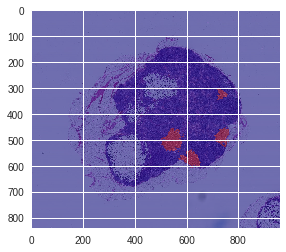

In [19]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

# plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

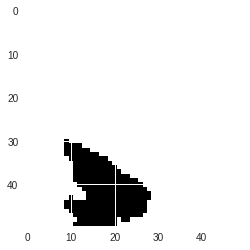

In [20]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

237731 tissue_pixels pixels (33.7 percent of the image)


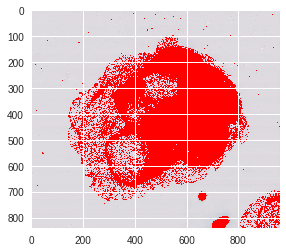

In [21]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [24]:
print(tissue_pixels[:10])

[(0, 487), (0, 488), (0, 489), (1, 364), (1, 365), (1, 487), (1, 488), (1, 489), (2, 364), (2, 365)]


#### my funs

In [0]:
def get_patches(image, coors, patch_size = (299,299), area = 'LT'):
  """
  input:
    - image
    - coors: list of (x, y)
    - area: 'LT', 'RB', 'C'
  output:
    - patch image, np.array
  """
  width, height, channel = image.shape
  
  patches_list = []
  for coor in coors:
    start_x, start_y = coor
    end_x = start_x + patch_size[0]
    end_y = start_y + patch_size[1]
    if end_x > width or end_y > height:
      continue
    else:
      patch_img = image[start_x:end_x,start_y:end_y,:]
      patches_list.append(patch_img)
  patches = np.array(patches_list)
  return(patches)
    

In [0]:
tmp = get_patches(slide_image, tissue_pixels)
print(tmp.shape)